# Задача:

Разработать алгоритмы классификации генетических мутаций на основе клинических данных (текста). Предсказать класс, в котором была генетическая мутация.

Описание файлов:

- **training_variants** - содержит описание генетических мутаций, используемых для обучения. 
Поля: 
ID - идентификатор строки, который используется для связи мутации с клиническими данными, Gene - ген, в котором находится эта генетическая мутация, Variation - изменение аминокислот для этой мутации, Class - 1-9 класс, в котором эта генетическая мутация была классифицирована
- **training_text** - файл с разделителями в виде двойной трубы (||), содержащий клинические данные (текст), используемые для классификации генетических мутаций. 
Поля: 
ID - идентификатор строки, используемой для связи клинических данных с генетической мутацией, Text - клинические данные, используемые для классификации генетической мутации)
- **test_variants** - содержит описание генетических мутаций, используемых для обучения. 
ID - идентификатор строки, который используется для связи мутации с клиническими данными, Gene - ген, в котором находится эта генетическая мутация, Variation - изменение аминокислот для этой мутации
- **test_text** - файл с разделителями в виде двойной трубы (||), содержащий клинические данные (текст), используемые для классификации генетических мутаций.  
Поля: 
ID - идентификатор строки, используемой для связи клинических данных с генетической мутацией, Text - клинические данные, используемые для классификации генетической мутации)
- **submissionSample** - пример файла отправки в правильном формате (итоговый файл, куда заливаем наши результаты)

In [1]:
!pip install py7zr

     |████████████████████████████████| 65 kB 431 kB/s eta 0:00:011
     |████████████████████████████████| 13.7 MB 7.3 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#Импортирование библиотек
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
import nltk
from collections import Counter
import sklearn
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV, train_test_split, ShuffleSplit, KFold
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, log_loss
import pickle
import py7zr

# 1. Exploratory Data Analysis

## Загрузка данных

Тренировочные данные

In [3]:
training_variants = pd.read_csv('/kaggle/input/msk-redefining-cancer-treatment/training_variants.zip')
training_text =pd.read_csv("/kaggle/input/msk-redefining-cancer-treatment/training_text.zip",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [4]:
training_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
training_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


Собираем информацию о мутациях в генах с информацией о них в научных статьях

In [6]:
train = pd.merge(training_variants, training_text, how = 'left', on = 'ID').fillna('')
train.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [7]:
train.shape

(3321, 5)

Тестовые данные

In [8]:
"""test_var = pd.read_csv('/kaggle/input/msk-redefining-cancer-treatment/test_variants.zip')
test_text =pd.read_csv("/kaggle/input/msk-redefining-cancer-treatment/test_text.zip",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
test = pd.merge(test_var, test_text, how = 'left', on = 'ID').fillna('')
test.head()""";

In [9]:
with py7zr.SevenZipFile('../input/msk-redefining-cancer-treatment/stage2_test_text.csv.7z', mode='r') as z:
    z.extractall()
with py7zr.SevenZipFile('../input/msk-redefining-cancer-treatment/stage2_test_variants.csv.7z', mode='r') as z:
    z.extractall()

test_variants = pd.read_csv("./stage2_test_variants.csv")
test_text =pd.read_csv("./stage2_test_text.csv",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
test = pd.merge(test_variants, test_text, how = 'left', on = 'ID').fillna('')

In [10]:
test.head()

,ID,Gene,Variation,TEXT
0,1,CHEK2,H371Y,The incidence of breast cancer is increasing i...
1,2,AXIN2,Truncating Mutations,An unselected series of 310 colorectal carcino...
2,3,WNT4,E216G,Mycosis fungoides and Sézary syndrome are prim...
3,4,SUCLA2,G118R,Regulated progression through the cell cycle ...
4,5,BRAF,T599insTT,Pilocytic astrocytoma (PA) is emerging as a tu...


In [11]:
test.shape

(986, 4)

In [12]:
df_all = pd.concat([train, test]).reset_index(drop=True)

In [13]:
df_all

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1.0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2.0,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2.0,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3.0,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4.0,Oncogenic mutations in the monomeric Casitas B...
...,...,...,...,...,...
4302,982,TP63,S580P,NaN,IκB kinase β (IKKβ) is involved in tumor devel...
4303,983,SCN4A,R672G,NaN,he identification of subtype-specific transloc...
4304,984,BRAF,N581H,NaN,Cardio-facio-cutaneous (CFC) syndrome (MIM 115...
4305,985,TSHR,S281N,NaN,Screening for tumor suppressor genes in breast...


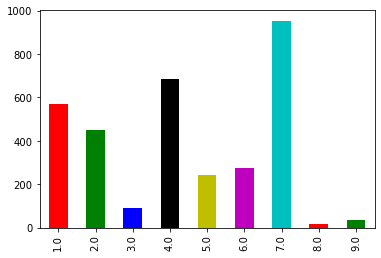

In [44]:
#График распределения классов
my_colors = list('rgbkymc')
df_all.Class.value_counts(sort=False).plot(kind='bar', color=my_colors);

In [15]:
df_all.Class.value_counts(sort=False) / df_all.shape[0]*100

1.0    13.187834
2.0    10.494544
3.0     2.066404
4.0    15.927560
5.0     5.618760
6.0     6.384955
7.0    22.126770
8.0     0.441142
9.0     0.859067
Name: Class, dtype: float64

# 2. Предобработка текстовых данных

https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing

In [16]:
 def preprocessing_text(text):
    PUNCT_TO_REMOVE = string.punctuation
    STOPWORDS = set(stopwords.words('english'))
    
    #Приводим текст к нижнему регистру
    text = text.lower()
    
    #Удаляем символы пунктуации, они нам не нужны
    text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
    
    #Удаление стопслов
    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])
    
    #Удаление редких слов
    cnt = Counter()
    n_rare_words = 10
    RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
    text = " ".join([word for word in str(text).split() if word not in RAREWORDS])
    
    #Stemming - приводим слова к базовой форме
    #stemmer = PorterStemmer()
    #text = " ".join([stemmer.stem(word) for word in text.split()])
    
    #Lemmatization - подобно стемматизации, но гарантия того, что слово принадлежит этому языку, работает медленнее
    #lemmatizer = WordNetLemmatizer()
    #wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
    #pos_tagged_text = nltk.pos_tag(text.split())    
    #text = " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])
    return text

In [17]:
df_all.loc[0]

ID                                                           0
Gene                                                    FAM58A
Variation                                 Truncating Mutations
Class                                                        1
TEXT         Cyclin-dependent kinases (CDKs) regulate a var...
Name: 0, dtype: object

In [18]:
preprocessing_text(df_all.TEXT[0])[:120]

'cyclindependent kinases cdks regulate variety fundamental cellular processes cdk10 stands one last orphan cdks activatin'

In [19]:
%%time
df_all['clean_text'] = df_all.TEXT.apply(lambda x: preprocessing_text(x))

CPU times: user 51.8 s, sys: 1.41 s, total: 53.3 s
Wall time: 53.3 s


Функция для подсчета слова в тексте, модет использоваться в качестве дополнительного генерирования фичей

In [20]:
def count_words(TEXT, Gene_Var):
    wordlist = TEXT.split(' ')
    cnt = 0
    for s in wordlist:
        if (Gene_Var==s):
            cnt+=1
    return cnt

In [21]:
#Что можно еще добавить? как пример

#df_all['Gene_cnt'] = df_all.apply(lambda x: count_words(x['TEXT'], x['Gene']), axis=1)
#df_all['Variation_cnt'] = df_all.apply(lambda x: count_words(x['TEXT'], x['Variation']), axis=1)

In [22]:
df_all

,ID,Gene,Variation,Class,TEXT,clean_text
0,0,FAM58A,Truncating Mutations,1.0,Cyclin-dependent kinases (CDKs) regulate a var...,cyclindependent kinases cdks regulate variety ...
1,1,CBL,W802*,2.0,Abstract Background Non-small cell lung canc...,abstract background nonsmall cell lung cancer ...
2,2,CBL,Q249E,2.0,Abstract Background Non-small cell lung canc...,abstract background nonsmall cell lung cancer ...
3,3,CBL,N454D,3.0,Recent evidence has demonstrated that acquired...,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4.0,Oncogenic mutations in the monomeric Casitas B...,oncogenic mutations monomeric casitas blineage...
...,...,...,...,...,...,...
4302,982,TP63,S580P,NaN,IκB kinase β (IKKβ) is involved in tumor devel...,iκb kinase β ikkβ involved tumor development p...
4303,983,SCN4A,R672G,NaN,he identification of subtype-specific transloc...,identification subtypespecific translocations ...
4304,984,BRAF,N581H,NaN,Cardio-facio-cutaneous (CFC) syndrome (MIM 115...,cardiofaciocutaneous cfc syndrome mim 115150 c...
4305,985,TSHR,S281N,NaN,Screening for tumor suppressor genes in breast...,screening tumor suppressor genes breast cancer...


Векторизация текста

In [23]:
def Vectorize_text(text, max_features=250, ngram_range=(1, 2), min_df=1):
    X_vect = list(text)
    tfidf = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range, max_features=max_features)
    #X_vect = tfidf.fit_transform(text).toarray() 
    X_vect = pd.DataFrame(tfidf.fit_transform(X_vect).toarray(), index=text.index)      
    return X_vect

In [24]:
with open('df_all.pickle', 'wb') as handle:
    pickle.dump(df_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
tfidf_features = Vectorize_text(df_all['clean_text'])

In [26]:
tfidf_features

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.097587,0.014601,0.026388,0.006454,0.020654,0.013415,0.044748,0.027473,0.007015,0.006964,...,0.049762,0.000000,0.018819,0.013711,0.034061,0.013206,0.019750,0.022782,0.021468,0.092802
1,0.083958,0.041379,0.021367,0.026130,0.016724,0.010863,0.020705,0.016685,0.005681,0.011279,...,0.000000,0.000000,0.020318,0.005551,0.011032,0.037428,0.005331,0.018448,0.023178,0.045087
2,0.083958,0.041379,0.021367,0.026130,0.016724,0.010863,0.020705,0.016685,0.005681,0.011279,...,0.000000,0.000000,0.020318,0.005551,0.011032,0.037428,0.005331,0.018448,0.023178,0.045087
3,0.122523,0.008147,0.022087,0.043216,0.038417,0.029943,0.028537,0.015331,0.007829,0.031090,...,0.000000,0.000000,0.042006,0.030604,0.053218,0.117910,0.014694,0.050851,0.007986,0.000000
4,0.054044,0.021562,0.009743,0.014297,0.035585,0.004953,0.018881,0.010143,0.005180,0.010285,...,0.000000,0.006267,0.004632,0.020248,0.005030,0.087765,0.019444,0.011215,0.021137,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4302,0.094593,0.005959,0.037695,0.047413,0.039338,0.021901,0.036526,0.005606,0.040086,0.045479,...,0.029014,0.027713,0.005121,0.011192,0.077848,0.026950,0.005374,0.092983,0.011683,0.000000
4303,0.072605,0.046008,0.023098,0.009039,0.009642,0.000000,0.013429,0.009619,0.009825,0.009754,...,0.004978,0.041603,0.013178,0.014401,0.004770,0.009248,0.027659,0.021271,0.005011,0.006498
4304,0.021071,0.011209,0.063309,0.037161,0.044926,0.048921,0.029446,0.013182,0.029623,0.026734,...,0.002729,0.000000,0.021672,0.015789,0.002615,0.015208,0.007581,0.000000,0.005494,0.000000
4305,0.017498,0.010472,0.037853,0.027774,0.029627,0.019244,0.009170,0.019705,0.020127,0.039961,...,0.020395,0.012175,0.026996,0.009834,0.019544,0.000000,0.018887,0.000000,0.000000,0.000000


Декомпозиция

In [27]:
svd = TruncatedSVD(n_components=50, n_iter=5, random_state=0)
truncated_tfidf = svd.fit_transform(tfidf_features)
df_tfidf_col_name = ["tfidf_"+str(i) for i in range(50)]
df_tfidf = pd.DataFrame(truncated_tfidf)
df_tfidf.columns = df_tfidf_col_name

In [28]:
df_tfidf[:4]

,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,...,tfidf_40,tfidf_41,tfidf_42,tfidf_43,tfidf_44,tfidf_45,tfidf_46,tfidf_47,tfidf_48,tfidf_49
0,0.654349,-0.055238,-0.132204,-0.308796,-0.157907,-0.159468,0.006244,-0.120779,0.035119,0.054510,...,-0.015926,-0.002358,0.057405,-0.127116,-0.007229,-0.018434,0.027659,0.016872,-0.013686,0.064609
1,0.666655,-0.124539,-0.262018,0.152875,-0.082306,0.165826,0.223222,-0.152247,-0.080941,0.042818,...,-0.156005,-0.108086,0.016178,-0.142069,-0.034036,-0.079037,-0.037494,-0.163716,-0.072116,-0.079733
2,0.666655,-0.124539,-0.262018,0.152875,-0.082306,0.165826,0.223222,-0.152247,-0.080941,0.042818,...,-0.156005,-0.108086,0.016178,-0.142069,-0.034036,-0.079037,-0.037494,-0.163716,-0.072116,-0.079733
3,0.708747,-0.026417,-0.193771,0.100403,0.038868,-0.002890,-0.093191,0.096907,0.048956,0.139955,...,-0.043519,-0.060314,-0.004468,0.004269,-0.126133,0.140475,0.035114,-0.043337,0.193847,-0.021574


Мешок слов

In [30]:
count_vectorizer = CountVectorizer(min_df=1, ngram_range=(1,1))
count_features = count_vectorizer.fit_transform(df_all['clean_text'])
count_svd = TruncatedSVD(n_components=50, n_iter=5, random_state=10)
count_bow = count_svd.fit_transform(count_features)
df_bow_col_name = ["bow_"+str(i) for i in range(50)]
df_bow = pd.DataFrame(count_bow)
df_bow.columns = df_bow_col_name

In [31]:
df_bow[:4]

,bow_0,bow_1,bow_2,bow_3,bow_4,bow_5,bow_6,bow_7,bow_8,bow_9,...,bow_40,bow_41,bow_42,bow_43,bow_44,bow_45,bow_46,bow_47,bow_48,bow_49
0,103.176928,-38.187298,-7.875072,2.349977,-28.815350,29.393078,-19.420483,-29.638929,0.590732,3.608385,...,-1.710330,-9.011084,6.728746,6.496240,-14.786006,-19.753654,-0.649059,-0.423375,6.013181,-2.460757
1,133.245729,30.881630,-1.225452,-13.928126,-34.208462,9.656688,-16.003933,4.831386,-1.137340,8.309026,...,3.060768,-3.527920,-7.796033,-2.451676,-0.111333,-3.572180,-0.216852,1.657824,7.472567,-0.968878
2,133.245729,30.881630,-1.225452,-13.928126,-34.208462,9.656688,-16.003933,4.831386,-1.137340,8.309026,...,3.060768,-3.527920,-7.796033,-2.451676,-0.111333,-3.572180,-0.216852,1.657824,7.472567,-0.968878
3,107.033108,14.700084,8.177444,14.726231,-16.548801,-10.150387,-6.122742,13.500503,-5.704044,11.854165,...,6.548147,-9.990566,7.376326,6.175515,-1.360810,-13.738526,8.167045,1.602904,12.597553,-11.973009


Закодируем Gene и Variation, чтобы привести информацию в двоичный вид

In [32]:
df_all = pd.get_dummies(df_all, columns=['Gene', 'Variation'], drop_first=True)

Соединяем таблицы

In [33]:
df_all = df_all.join(df_tfidf)
df_all = df_all.join(df_bow)

In [34]:
df_all[:5]

,ID,Class,TEXT,clean_text,Gene_ABCC6,Gene_ABL1,Gene_ACVR1,Gene_ADAMTS13,Gene_ADGRG1,Gene_AGO2,...,bow_40,bow_41,bow_42,bow_43,bow_44,bow_45,bow_46,bow_47,bow_48,bow_49
0,0,1.0,Cyclin-dependent kinases (CDKs) regulate a var...,cyclindependent kinases cdks regulate variety ...,0,0,0,0,0,0,...,-1.710330,-9.011084,6.728746,6.496240,-14.786006,-19.753654,-0.649059,-0.423375,6.013181,-2.460757
1,1,2.0,Abstract Background Non-small cell lung canc...,abstract background nonsmall cell lung cancer ...,0,0,0,0,0,0,...,3.060768,-3.527920,-7.796033,-2.451676,-0.111333,-3.572180,-0.216852,1.657824,7.472567,-0.968878
2,2,2.0,Abstract Background Non-small cell lung canc...,abstract background nonsmall cell lung cancer ...,0,0,0,0,0,0,...,3.060768,-3.527920,-7.796033,-2.451676,-0.111333,-3.572180,-0.216852,1.657824,7.472567,-0.968878
3,3,3.0,Recent evidence has demonstrated that acquired...,recent evidence demonstrated acquired uniparen...,0,0,0,0,0,0,...,6.548147,-9.990566,7.376326,6.175515,-1.360810,-13.738526,8.167045,1.602904,12.597553,-11.973009
4,4,4.0,Oncogenic mutations in the monomeric Casitas B...,oncogenic mutations monomeric casitas blineage...,0,0,0,0,0,0,...,-7.766043,-6.534865,0.816979,-9.774388,1.226150,-14.489876,-3.904913,20.095531,28.091606,-2.176289


In [35]:
df_all.shape

(4307, 4424)

In [36]:
df_train = df_all.iloc[:train.shape[0]]
X = df_train.iloc[:,4:]
y = df_train['Class']

In [37]:
df_test = df_all.iloc[train.shape[0]:]
X_test = df_test.iloc[:,4:]

# 3. Обучение

## XGBClassifier

Разбиваем на тренировочные данные и данные для валидации модели

In [38]:
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
X_train = X.copy()
y_train = y.copy()

Делаем поиск оптимальных гиперпараметров

In [39]:
"""
def score_func(estimator, X, y):
    score1 = log_loss(y,estimator.predict(X,
                           ntree_limit=estimator.best_ntree_limit),
                          labels=list(range(1,10)))
    return -score1

xgb = XGBClassifier(
    objective = 'multi:softprob',
    eval_metric = 'mlogloss',
    num_class = 9,
    nthread=4,
    seed=10
)

parameters = {
    'max_depth': range (4, 7, 1),
    'learning_rate': [0.1, 0.01, 0.05]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=parameters,
    scoring = score_func,
    n_jobs = 10,
    cv = 3,
    verbose=True
)

grid_search.fit(X_train, y_train)""";

Классы распознаются с 0, поэтому вычитаем 1, чтобы корректно запустился алгоритм, после, мы ее прибавим к нашему предикту

In [40]:
y_train = y_train-1

In [45]:
xgb_param = {'objective': 'multi:softprob',
          'eval_metric' : 'mlogloss',
          'learning_rate' : 0.05,
          'max_depth' : 5,
          'num_class' : 9,
          'nthread': 4,
          'seed': 10}

dtrain_xgb = xgb.DMatrix(X_train, label=y_train)

xbg_result = xgb.cv(xgb_param, 
                    dtrain_xgb, 
                    num_boost_round=300, 
                    nfold=3,
                    stratified=True, 
                    early_stopping_rounds=50, 
                    verbose_eval=100, 
                    show_stdv=True)

[0]	train-mlogloss:2.11078+0.00323	test-mlogloss:2.12429+0.00397
[100]	train-mlogloss:0.53550+0.02331	test-mlogloss:1.00816+0.04288
[200]	train-mlogloss:0.34996+0.02047	test-mlogloss:0.97353+0.04872


Выбираем номер наилучшего раунда

In [46]:
num_round_xgb = len(xbg_result['test-mlogloss-mean'])
print('num boost rounds xgb=' + str(num_round_xgb))

num boost rounds xgb=195


Тренируем нашу итоговую модель

In [47]:
xgb_cl = xgb.train(xgb_param, dtrain_xgb, num_boost_round=num_round_xgb)

Подготавливаем тестовые данные, чтобы модель воспринимала формат входных тестовых данных как и у тренировочных

In [48]:
xgtest = xgb.DMatrix(X_test)

Предикт наших тестовых данных

In [49]:
y_pred = xgb_cl.predict(xgtest)

Создаем наш датафрейм и записываем итоговые результаты

In [50]:
classes = ['class1', 'class2', 'class3', 'class4','class5', 'class6', 'class7', 'class8','class9']
submit = pd.DataFrame(y_pred, columns=classes)
submit['ID'] = test['ID'].values

In [51]:
submit = submit[['ID', 'class1', 'class2', 'class3', 'class4','class5', 'class6', 'class7', 'class8','class9']]

Иииии записываем в наш файл! :)

In [52]:
submit.to_csv('submission.csv', index=False)